In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet169,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = DenseNet169(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 62s 20ms/step - loss: 0.4064 - acc: 0.8839 - val_loss: 1.3519 - val_acc: 0.5489
Epoch 2/100
3144/3144 [==============================] - 47s 15ms/step - loss: 0.2465 - acc: 0.9132 - val_loss: 2.2437 - val_acc: 0.6150
Epoch 3/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1890 - acc: 0.9323 - val_loss: 0.6393 - val_acc: 0.8221
Epoch 4/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1671 - acc: 0.9497 - val_loss: 0.3960 - val_acc: 0.8259
Epoch 5/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1280 - acc: 0.9558 - val_loss: 0.1965 - val_acc: 0.9301
Epoch 6/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1195 - acc: 0.9596 - val_loss: 0.3460 - val_acc: 0.9123
Epoch 7/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1709 - acc: 0.9485 - val_loss: 0.5531 - val_acc: 0

3144/3144 [==============================] - 46s 15ms/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.1610 - val_acc: 0.9720
Epoch 61/100
3144/3144 [==============================] - 47s 15ms/step - loss: 0.0037 - acc: 0.9981 - val_loss: 0.2308 - val_acc: 0.9632
Epoch 62/100
3144/3144 [==============================] - 47s 15ms/step - loss: 7.1459e-04 - acc: 1.0000 - val_loss: 0.1891 - val_acc: 0.9746
Epoch 63/100
3144/3144 [==============================] - 47s 15ms/step - loss: 0.0174 - acc: 0.9952 - val_loss: 0.5020 - val_acc: 0.8793
Epoch 64/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.0197 - acc: 0.9920 - val_loss: 0.1650 - val_acc: 0.9632
Epoch 65/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.0259 - acc: 0.9898 - val_loss: 0.2267 - val_acc: 0.9759
Epoch 66/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.0066 - acc: 0.9981 - val_loss: 0.2566 - val_acc: 0.9619
Epoch 67/100
3144/3144 [===================

3145/3145 [==============================] - 46s 15ms/step - loss: 0.1228 - acc: 0.9577 - val_loss: 0.1815 - val_acc: 0.9275
Epoch 19/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.1033 - acc: 0.9657 - val_loss: 0.2047 - val_acc: 0.9504
Epoch 20/100
3145/3145 [==============================] - 45s 14ms/step - loss: 0.1003 - acc: 0.9676 - val_loss: 0.2882 - val_acc: 0.9440
Epoch 21/100
3145/3145 [==============================] - 45s 14ms/step - loss: 0.1316 - acc: 0.9520 - val_loss: 0.2050 - val_acc: 0.9351
Epoch 22/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0833 - acc: 0.9742 - val_loss: 0.2312 - val_acc: 0.9389
Epoch 23/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0958 - acc: 0.9666 - val_loss: 0.2211 - val_acc: 0.9567
Epoch 24/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0711 - acc: 0.9755 - val_loss: 0.2558 - val_acc: 0.9491
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 46s 15ms/step - loss: 0.0182 - acc: 0.9943 - val_loss: 0.2364 - val_acc: 0.9606
Epoch 78/100
3145/3145 [==============================] - 47s 15ms/step - loss: 0.0155 - acc: 0.9952 - val_loss: 0.2307 - val_acc: 0.9618
Epoch 79/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.2260 - val_acc: 0.9707
Epoch 80/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0216 - acc: 0.9930 - val_loss: 0.4426 - val_acc: 0.9135
Epoch 81/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0276 - acc: 0.9908 - val_loss: 0.1934 - val_acc: 0.9733
Epoch 82/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0094 - acc: 0.9962 - val_loss: 0.2156 - val_acc: 0.9720
Epoch 83/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0085 - acc: 0.9984 - val_loss: 0.2037 - val_acc: 0.9720
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 46s 15ms/step - loss: 0.0435 - acc: 0.9838 - val_loss: 0.1011 - val_acc: 0.9758
Epoch 36/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0427 - acc: 0.9876 - val_loss: 0.1367 - val_acc: 0.9644
Epoch 37/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0286 - acc: 0.9905 - val_loss: 0.1530 - val_acc: 0.9733
Epoch 38/100
3145/3145 [==============================] - 45s 14ms/step - loss: 0.0722 - acc: 0.9755 - val_loss: 0.1215 - val_acc: 0.9707
Epoch 39/100
3145/3145 [==============================] - 47s 15ms/step - loss: 0.0263 - acc: 0.9911 - val_loss: 0.1451 - val_acc: 0.9631
Epoch 40/100
3145/3145 [==============================] - 45s 14ms/step - loss: 0.0334 - acc: 0.9873 - val_loss: 0.1437 - val_acc: 0.9644
Epoch 41/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0165 - acc: 0.9933 - val_loss: 0.1576 - val_acc: 0.9758
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 46s 15ms/step - loss: 0.0042 - acc: 0.9984 - val_loss: 0.1922 - val_acc: 0.9733
Epoch 95/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0439 - acc: 0.9860 - val_loss: 0.4610 - val_acc: 0.8982
Epoch 96/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0172 - acc: 0.9940 - val_loss: 0.1424 - val_acc: 0.9720
Epoch 97/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0106 - acc: 0.9968 - val_loss: 0.2249 - val_acc: 0.9707
Epoch 98/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0540 - acc: 0.9819 - val_loss: 0.2209 - val_acc: 0.9555
Epoch 99/100
3145/3145 [==============================] - 46s 14ms/step - loss: 0.0225 - acc: 0.9940 - val_loss: 0.2049 - val_acc: 0.9695
Epoch 100/100
786/786 [==============================] - 4s 5ms/step
[2] Test acurracy: 0.9771 (4603.0796 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [======

3145/3145 [==============================] - 46s 15ms/step - loss: 0.0263 - acc: 0.9901 - val_loss: 0.2290 - val_acc: 0.9606
Epoch 53/100
3145/3145 [==============================] - 45s 14ms/step - loss: 0.0186 - acc: 0.9946 - val_loss: 0.2609 - val_acc: 0.9593
Epoch 54/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0207 - acc: 0.9921 - val_loss: 0.2332 - val_acc: 0.9606
Epoch 55/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0603 - acc: 0.9822 - val_loss: 0.1972 - val_acc: 0.9618
Epoch 56/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0295 - acc: 0.9921 - val_loss: 0.2187 - val_acc: 0.9580
Epoch 57/100
3145/3145 [==============================] - 46s 14ms/step - loss: 0.0123 - acc: 0.9959 - val_loss: 0.5067 - val_acc: 0.9249
Epoch 58/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.0164 - acc: 0.9949 - val_loss: 0.2247 - val_acc: 0.9682
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 46s 15ms/step - loss: 0.1646 - acc: 0.9421 - val_loss: 0.3066 - val_acc: 0.9097
Epoch 11/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.1405 - acc: 0.9552 - val_loss: 0.2665 - val_acc: 0.8944
Epoch 12/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.1433 - acc: 0.9520 - val_loss: 0.2639 - val_acc: 0.9415
Epoch 13/100
3145/3145 [==============================] - 46s 15ms/step - loss: 0.1343 - acc: 0.9583 - val_loss: 0.9233 - val_acc: 0.7036
Epoch 14/100
3145/3145 [==============================] - 45s 14ms/step - loss: 0.1569 - acc: 0.9447 - val_loss: 0.2279 - val_acc: 0.9313
Epoch 15/100
3145/3145 [==============================] - 49s 16ms/step - loss: 0.1639 - acc: 0.9520 - val_loss: 0.2791 - val_acc: 0.9008
Epoch 16/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.1498 - acc: 0.9533 - val_loss: 0.2187 - val_acc: 0.9466
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 52s 16ms/step - loss: 0.0233 - acc: 0.9917 - val_loss: 0.4273 - val_acc: 0.9351
Epoch 70/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0617 - acc: 0.9825 - val_loss: 0.3133 - val_acc: 0.9427
Epoch 71/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0124 - acc: 0.9955 - val_loss: 0.3093 - val_acc: 0.9326
Epoch 72/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0324 - acc: 0.9917 - val_loss: 0.4478 - val_acc: 0.9084
Epoch 73/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0232 - acc: 0.9927 - val_loss: 0.3350 - val_acc: 0.9351
Epoch 74/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0107 - acc: 0.9968 - val_loss: 0.3306 - val_acc: 0.9186
Epoch 75/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0162 - acc: 0.9943 - val_loss: 0.2681 - val_acc: 0.9504
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9466


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

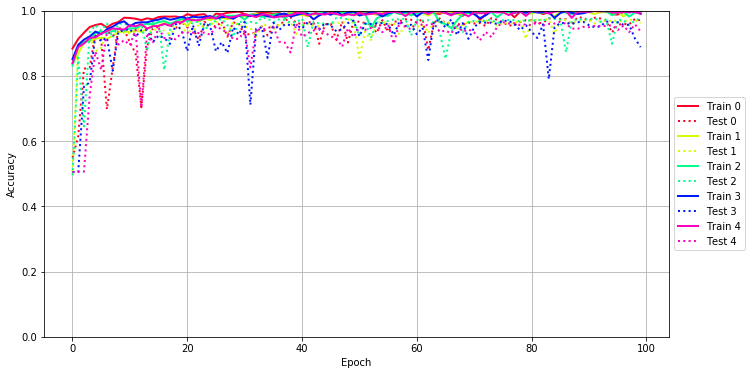

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

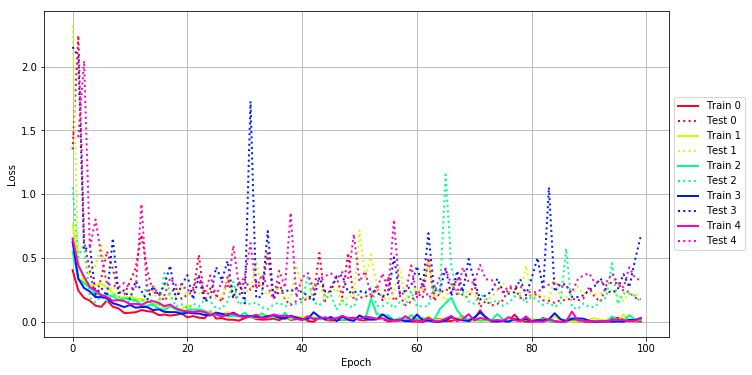

In [12]:
plot_loss(history)

Plotting the confusion matrix


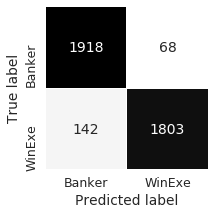

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


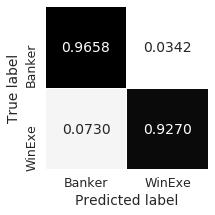

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'acc': [0.8839058524173028, 0.9131679389312977, 0.9322519083969466, 0.9497455470737913, 0.9557888040712468, 0.9596055979643766, 0.9484732824427481, 0.9599236641221374, 0.9650127226463104, 0.9783715012722646, 0.9774173027989822, 0.9751908396946565, 0.9710559796437659, 0.9764631043256997, 0.9732824427480916, 0.9802798982188295, 0.9818702290076335, 0.9815521628498728, 0.9821882951653944, 0.9783715012722646, 0.9891857506361323, 0.9847328244274809, 0.9875954198473282, 0.9891857506361323, 0.9732824427480916, 0.9907760814249363, 0.9888676844783715, 0.9936386768447837, 0.9955470737913485, 0.9968193384223919, 0.9895038167938931, 0.9853689567430025, 0.9914122137404581, 0.9930025445292621, 0.9933206106870229, 0.9907760814249363, 0.9926844783715013, 0.9869592875318066, 0.9949109414758269, 0.9926844783715013, 0.9895038167938931, 0.9987277353689568, 0.9993638676844784, 0.986323155216285, 0.9939567430025446, 0.9958651399491094, 0.9952290076335878, 0.9945928753180662, 0.9933206106870229, 0.9917302798

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

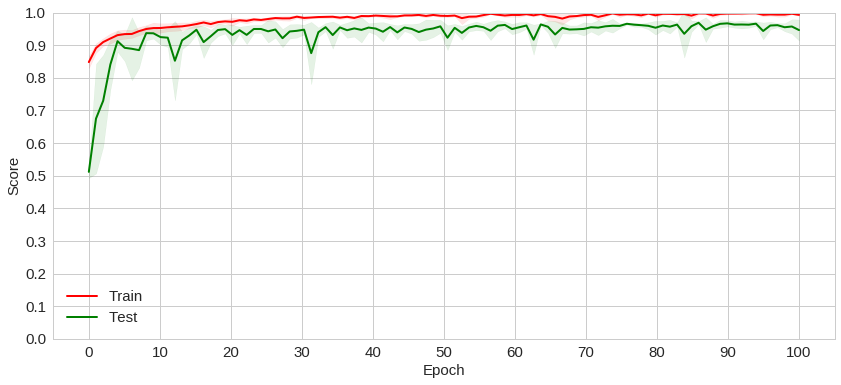

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

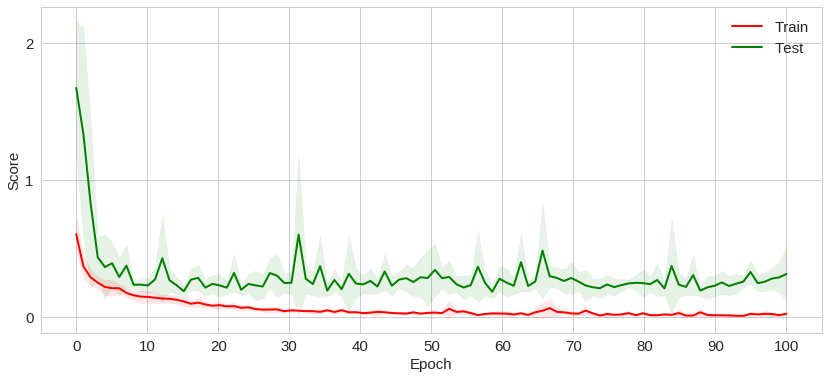

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'acc': [0.8839058524173028, 0.9131679389312977, 0.9322519083969466, 0.9497455470737913, 0.9557888040712468, 0.9596055979643766, 0.9484732824427481, 0.9599236641221374, 0.9650127226463104, 0.9783715012722646, 0.9774173027989822, 0.9751908396946565, 0.9710559796437659, 0.9764631043256997, 0.9732824427480916, 0.9802798982188295, 0.9818702290076335, 0.9815521628498728, 0.9821882951653944, 0.9783715012722646, 0.9891857506361323, 0.9847328244274809, 0.9875954198473282, 0.9891857506361323, 0.9732824427480916, 0.9907760814249363, 0.9888676844783715, 0.9936386768447837, 0.9955470737913485, 0.9968193384223919, 0.9895038167938931, 0.9853689567430025, 0.9914122137404581, 0.9930025445292621, 0.9933206106870229, 0.9907760814249363, 0.9926844783715013, 0.9869592875318066, 0.9949109414758269, 0.9926844783715013, 0.9895038167938931, 0.9987277353689568, 0.9993638676844784, 0.986323155216285, 0.9939567430025446, 0.9958651399491094, 0.9952290076335878, 0.9945928753180662, 0.9933206106870229, 0.9917302798982188, 0.9952290076335878, 0.9952290076335878, 0.9923664122137404, 0.9885496183206107, 0.9907760814249363, 0.9993638676844784, 0.9974554707379135, 0.9958651399491094, 0.9914122137404581, 0.9987277353689568, 0.9980916030534351, 1.0, 0.9952290076335878, 0.9920483460559797, 0.989821882951654, 0.9980916030534351, 0.9977735368956743, 0.9914122137404581, 0.9840966921119593, 0.9968193384223919, 0.9955470737913485, 0.9720101781170484, 0.9885496183206107, 0.9987277353689568, 0.9977735368956743, 0.9945928753180662, 0.9971374045801527, 0.9796437659033079, 0.996501272264631, 0.9984096692111959, 0.9987277353689568, 0.9968193384223919, 0.9895038167938931, 0.9958651399491094, 1.0, 0.9996819338422391, 0.9980916030534351, 0.996501272264631, 0.9987277353689568, 1.0, 0.9996819338422391, 1.0, 0.9990458015267175, 0.9996819338422391, 0.9888676844783715, 0.9879134860050891, 0.9952290076335878, 0.9987277353689568, 0.9980916030534351, 0.9977735368956743], 'val_loss': [1.3519260029780669, 2.243700946329737, 0.6393038615716913, 0.39600523151315303, 0.19648525683064927, 0.3460325659731973, 0.5530982636284495, 0.41817494613394196, 0.23820441288180091, 0.21679052865793016, 0.31482628196137075, 0.4253824111429224, 0.6821893639909873, 0.4088386418404391, 0.23541016563884984, 0.21958689571694345, 0.16571798826434106, 0.22868265569337415, 0.26828881417989275, 0.18168118139527728, 0.21486004218302332, 0.23724204513186345, 0.5265847253304871, 0.16626282032991002, 0.2636079588006197, 0.21634307498966723, 0.15858070682402903, 0.3507286171980464, 0.18157114351667497, 0.20213495933224732, 0.33417571183034306, 0.2515596747374709, 0.31561647413153965, 0.25129988954758703, 0.5386245737035844, 0.17956397109670894, 0.3082470412569042, 0.17541022443187718, 0.1330239028046251, 0.16445615706843142, 0.18530513013279942, 0.1694911009877959, 0.21183001311815658, 0.5402542922929523, 0.16278892147722815, 0.2752859355639456, 0.35098061018553595, 0.19530050200240076, 0.5407196880280102, 0.1704856001569628, 0.1871486222949745, 0.20431164356756115, 0.19463560156514714, 0.28045673292897066, 0.1703968075577374, 0.35692073408059916, 0.16662543122853382, 0.2080487623166416, 0.13183616388593877, 0.1610412489049778, 0.23079045454291341, 0.18911616628248817, 0.5019747449103311, 0.16497648440184856, 0.22667090731774714, 0.25658257197851253, 0.2344731942645784, 0.3421446169003869, 0.20165686358566356, 0.19568398859465366, 0.3003146320305245, 0.11633276071262177, 0.16701667868618628, 0.12984947455772117, 0.14163701990577143, 0.17270047019139345, 0.2623960673533545, 0.2685826638886697, 0.1890910091014695, 0.1850152610709596, 0.2137743082972009, 0.2168221579596289, 0.16971558787596452, 0.16653904871856248, 0.15080633968291768, 0.17151277860918135, 0.17138423353878562, 0.185836260614525, 0.168632334973794, 0.1842358128567432, 0.271173189918409, 0.19372438161393238, 0.16018178807987285, 0.28990291344569397, 0.3115294313264166, 0.3043322333333963, 0.24257098838914634, 0.23534928176563263, 0.1910171574264915, 0.1786833993321802], 'val_acc': [0.5489199503858632, 0.6149936472900032, 0.8221092751247304, 0.8259212199735824, 0.9301143590043733, 0.9123252858958069, 0.6975857687420585, 0.8233799242912738, 0.9466327827191868, 0.9428208391578558, 0.9021601027121537, 0.8691232533891138, 0.7039390094246919, 0.8894536224071983, 0.9453621346886912, 0.9504447273408291, 0.9606099115847936, 0.9555273189326556, 0.9466327837794981, 0.9656925037067757, 0.9491740787801779, 0.944091487718507, 0.9110546378653113, 0.9656925037067757, 0.9567979669631512, 0.9504447268106735, 0.9669631517372713, 0.9199491740787802, 0.9644218551461246, 0.959339263554298, 0.9250317662007624, 0.928843710292249, 0.9326556543837357, 0.9517153753713247, 0.9237611181702668, 0.9517153759014804, 0.9555273194628113, 0.9682337992376112, 0.9796696315120712, 0.9618805590851334, 0.959339263554298, 0.9644218551461246, 0.9644218551461246, 0.8983481586206671, 0.9580686155238024, 0.9593392630241423, 0.9097839908951271, 0.9669631512071156, 0.9021601016518425, 0.9682337997677668, 0.96569250317662, 0.9618805590851334, 0.9580686160539581, 0.9313850063532402, 0.9707750952986023, 0.9351969504447268, 0.9656925037067757, 0.9682337992376112, 0.9733163913595934, 0.9720457438592535, 0.9631512076457847, 0.974587039390089, 0.8792884376330782, 0.9631512076457847, 0.9758576874205845, 0.9618805590851334, 0.963151207115629, 0.9593392630241423, 0.9567979674933069, 0.963151207115629, 0.9606099110546379, 0.9618805596152891, 0.9529860228716646, 0.9771283359812357, 0.9720457438592535, 0.9644218551461246, 0.9542566709021602, 0.9555273189326556, 0.9644218556762802, 0.970775095828758, 0.970775095828758, 0.9606099115847936, 0.9631512076457847, 0.9758576874205845, 0.9771283359812357, 0.9745870399202446, 0.9733163924199048, 0.9567979674933069, 0.9796696315120712, 0.9783989840117313, 0.9682337992376112, 0.9783989834815756, 0.9758576879507401, 0.9682337997677668, 0.9326556549138914, 0.9567979674933069, 0.9593392630241423, 0.9580686155238024, 0.9745870399202446, 0.9695044477982624], 'loss': [0.40643069549977934, 0.2465041211164028, 0.1890209537691439, 0.16706408164049227, 0.12803617595640454, 0.1195370931481663, 0.1708513798888858, 0.11981790153541941, 0.10699062784019923, 0.07053788464976138, 0.07286848557482618, 0.07723270571356966, 0.09402009673445051, 0.0851695975359842, 0.07980078119907821, 0.054790627284795425, 0.05848913100659468, 0.0508523397568291, 0.05652127276635646, 0.06663650005425471, 0.03707933718689336, 0.046683582224297804, 0.034431489730954674, 0.03003920211886831, 0.08438368091767336, 0.027583248511610824, 0.03054794986168297, 0.01881259533527198, 0.018284350167663707, 0.011311155345274458, 0.03138882858354261, 0.045074961955111674, 0.023050070058230936, 0.01883530746261191, 0.020355294435647903, 0.02731887093807675, 0.01465863193603517, 0.039256533812974406, 0.01660614100052488, 0.023070788705420016, 0.03608056389724921, 0.0075822083444301094, 0.002432995945914754, 0.03771944720766157, 0.018931917297821517, 0.011299521515442713, 0.015847077078799007, 0.016564076619815796, 0.02010344553152646, 0.02854754782907067, 0.017281213057530765, 0.01311910376707902, 0.02394851456677989, 0.03129672839361985, 0.024389996333980847, 0.005396270200032861, 0.007902251634204592, 0.0129916950304586, 0.02238102490124965, 0.004649862376959795, 0.003716704926537621, 0.0007145937573252045, 0.01740437636862093, 0.019689243699596667, 0.025872877641939723, 0.006614042227099807, 0.008484267578455093, 0.02492700446095364, 0.0450412484928068, 0.006387870092271962, 0.020622471880632643, 0.0916582616685911, 0.032104895113370176, 0.00690188944631457, 0.0061037508110359075, 0.011208495789804554, 0.007612576831139061, 0.05817633233711173, 0.008415046555233608, 0.0032985235962982276, 0.0033739636224875726, 0.00735483323154323, 0.03233209242196136, 0.009818924950040598, 0.0008021719684333656, 0.0013942340670061012, 0.0073044820467822015, 0.01376015417531157, 0.0025568087368542216, 0.0009341861896442683, 0.001982406911752904, 0.0009305609036937428, 0.002447944189191883, 0.0018594973245938378, 0.03353484987749412, 0.03229243986323164, 0.019694339516264585, 0.005687605493754055, 0.004732629643959712, 0.0050934819099402884]},
{'acc': [0.8356120827088106, 0.868362480127186, 0.9030206677455023, 0.9068362480316708, 0.9141494435801605, 0.9173290937996821, 0.9135135135324657, 0.9230524642289348, 0.9335453100158982, 0.9370429252971716, 0.934181240063593, 0.9405405405500167, 0.9341812401014974, 0.9453100159361556, 0.9529411764705882, 0.9542130365659778, 0.9621621623516841, 0.9577106518282988, 0.9656597774244833, 0.9675675675675676, 0.951987281588568, 0.9742448332578844, 0.9666136725149777, 0.975516693163752, 0.9710651828298887, 0.9777424483306836, 0.9774244833068363, 0.9742448332578844, 0.9774244833068363, 0.985691573926868, 0.9825119236883942, 0.9834658187599364, 0.9904610492845787, 0.9841017488076311, 0.9895071542130366, 0.9847376788553259, 0.9828298887122416, 0.9821939586834991, 0.9939586645468999, 0.9879173290937997, 0.9866454689984102, 0.9837837837837838, 0.9882352941176471, 0.9891891891891892, 0.9895071542130366, 0.9920508744038156, 0.9926868044515104, 0.9885532591414944, 0.9961844197138314, 0.9901430842986357, 0.9860095389507154, 0.9914149443561209, 0.9920508744038156, 0.9885532591414944, 0.9926868044704625, 0.9901430842607313, 0.9968203497615262, 0.9936406995420046, 0.9907790143084261, 0.9879173290937997, 0.9955484896661367, 0.9923688394845195, 0.9847376788553259, 0.9952305246422893, 0.9949125596184419, 0.992368839427663, 0.9917329093799682, 0.9901430842986357, 0.9885532591414944, 0.9939586645468999, 0.9955484896661367, 0.9980922098569157, 0.997456279809221, 0.9990461049284579, 0.9977742448330683, 0.9939586645468999, 0.9942766295707473, 0.9952305246422893, 0.9980922098569157, 0.9930047694753578, 0.9907790143084261, 0.9961844197138314, 0.9984101748807631, 0.9990461049663623, 0.9815580288063741, 0.9971383147853736, 0.9987281399046105, 0.9987281399046105, 0.9987281399046105, 0.9987281399046105, 0.9949125598079639, 0.989825119236884, 0.9955484896661367, 0.9952305246422893, 0.9984101748807631, 0.9971383148422301, 0.9818759936406996, 0.9977742448330683, 0.997456279809221, 0.9923688396171849], 'val_loss': [2.3222845107999466, 0.38399947091519987, 0.29753388369659733, 0.4032842966777678, 0.44014809597236204, 0.6189537641352977, 0.23107060715650934, 0.28147801524620625, 0.2256575512697413, 0.23315402812326835, 0.2149328471140097, 0.18181611769583844, 0.16077945303674265, 0.20960382453661233, 0.2423446841594827, 0.15944351006830088, 0.2984349772063944, 0.18154099869420964, 0.20473545052658568, 0.28823887432022516, 0.20499349383248666, 0.23117754383737804, 0.2211472739207229, 0.25584677898659164, 0.21282265289821697, 0.18299046189834675, 0.19047006861835186, 0.337026019681674, 0.21124480533444395, 0.2930813989075939, 0.22375507955143167, 0.26135133327229026, 0.46544671188340864, 0.25087142775057986, 0.21315183730336243, 0.27089470818297556, 0.23849108098052207, 0.18387390026981462, 0.19229801800593724, 0.44250404706046176, 0.25466200850166987, 0.1765526729107434, 0.30188372163410104, 0.29107328273988337, 0.18161716017843657, 0.24014881144588193, 0.26153810269112815, 0.14098950956993128, 0.2032397111399252, 0.2004407637243979, 0.7197389750817151, 0.3380364112404315, 0.5283820676610215, 0.28876973694971225, 0.1931193379941367, 0.17512440034982205, 0.23732460866338317, 0.4233490405829002, 0.17623435219384861, 0.25222554991528884, 0.2594886068639798, 0.24033686489421816, 0.47924956750616277, 0.18976178808960087, 0.22708044960649337, 0.16777176486859074, 0.30946935148086263, 0.23390080451774325, 0.20142819709322266, 0.2480923127981807, 0.20836897123408377, 0.17361601408003444, 0.17846015470550317, 0.19430327969264807, 0.25104142050473577, 0.30561141697916316, 0.23643158330657915, 0.2306790091270645, 0.2260321947626305, 0.44258709095001375, 0.19344009506266147, 0.21557571227409303, 0.20373955370811647, 0.18488092240154666, 0.34783767757812306, 0.19353374538289408, 0.19244529111959566, 0.21662538658214955, 0.2760905499217882, 0.2229600566636624, 0.22679086815144614, 0.217073275804823, 0.22360859993143845, 0.23841594675096384, 0.24819528134239058, 0.2113446997462016, 0.16286212216076884, 0.23384021670623534, 0.20625078005677103, 0.22661294473771185], 'val_acc': [0.5050890585241731, 0.8931297717506952, 0.9083969480815431, 0.9236641221374046, 0.8753180655510978, 0.8854961847227645, 0.9363867684478372, 0.9402035623409669, 0.9478371501272265, 0.9312977099236641, 0.9300254446859578, 0.9363867684478372, 0.9541984732824428, 0.9376590324722174, 0.9363867678411741, 0.950381679389313, 0.9376590330788804, 0.9274809160305344, 0.950381679389313, 0.9440203562340967, 0.9351145038167938, 0.9389312977099237, 0.9567430025445293, 0.9491094141516067, 0.9567430025445293, 0.9669211195928753, 0.9541984732824428, 0.9312977099236641, 0.9643765903307888, 0.9541984726757797, 0.9503816787826499, 0.9478371501272265, 0.9185750636132316, 0.9567430019378662, 0.955470737913486, 0.9427480909963903, 0.9567430025445293, 0.9592875311999527, 0.965648854355169, 0.9287531806615776, 0.955470737913486, 0.9592875318066157, 0.9541984732824428, 0.9516539440203562, 0.9592875318066157, 0.9592875311999527, 0.9631043256997456, 0.9618320604620393, 0.9732824427480916, 0.9618320610687023, 0.8549618320610687, 0.9363867678411741, 0.9096692113475945, 0.9618320610687023, 0.9669211195928753, 0.9580152665689095, 0.960559796437659, 0.926208650792828, 0.9592875318066157, 0.9529262080447365, 0.9503816795409787, 0.955470737913486, 0.9312977099236641, 0.9669211195928753, 0.9669211195928753, 0.9643765903307888, 0.9618320610687023, 0.94529262086514, 0.9567430019378662, 0.9656488549618321, 0.9656488549618321, 0.9669211195928753, 0.9694656488549618, 0.9669211195928753, 0.9541984732824428, 0.9618320610687023, 0.9605597958309959, 0.9618320610687023, 0.9707379128793421, 0.9134860044823955, 0.9732824427480916, 0.9720101781170484, 0.9720101781170484, 0.9732824427480916, 0.9300254446859578, 0.9707379134860051, 0.9720101781170484, 0.9618320610687023, 0.9669211195928753, 0.9681933842239185, 0.9707379134860051, 0.960559796437659, 0.9694656488549618, 0.9694656488549618, 0.9681933842239185, 0.9694656488549618, 0.9669211195928753, 0.9720101781170484, 0.9707379128793421, 0.9618320610687023], 'loss': [0.7721026037758977, 0.46770707578509335, 0.32070072250165316, 0.2920132559793742, 0.2898376623378839, 0.303515890411239, 0.2713665960513541, 0.22779457500183714, 0.19413009939540551, 0.19240902526769046, 0.1957532597548774, 0.18475984153952243, 0.18039161597981174, 0.16388227243112646, 0.13716125515288125, 0.14047858066655494, 0.11322462419447725, 0.12276557333329145, 0.10329604089757596, 0.1003335130091502, 0.13159274992152503, 0.0833069368225592, 0.09580543874651905, 0.07114066530780834, 0.0791540037864295, 0.0553179792384654, 0.06273311266826617, 0.07869666208333924, 0.05728243902615836, 0.044855786797802284, 0.0458759549483457, 0.044781675921169675, 0.031920037463522816, 0.047382054967429664, 0.030909649894198192, 0.04542468189867435, 0.04284084319732624, 0.04860694702234954, 0.021232788589806286, 0.04355000392148872, 0.03639289568220369, 0.04334743516875019, 0.03571730409252838, 0.029736538134983167, 0.0299275775305299, 0.025428828447829527, 0.022609222792969966, 0.0319697660947032, 0.014759449036688277, 0.03114966125609146, 0.03627004461727196, 0.022217620980876998, 0.023400575855216797, 0.03438822568878413, 0.02314529242821331, 0.0324030032999652, 0.007394304065637524, 0.02197771095668909, 0.024659185933111314, 0.02930351225369601, 0.012763977744414831, 0.02289718965546706, 0.04275931482774647, 0.01525944414595216, 0.021601134458844016, 0.02138614048154148, 0.023993304423360073, 0.03122416242230861, 0.037513743145011005, 0.017678831436561935, 0.011286793023822862, 0.007762110602051318, 0.011210847290024377, 0.0038764467056172426, 0.006477201707132378, 0.017559470014985392, 0.01823818843223381, 0.015509832917382445, 0.006167505516243647, 0.021626331314245767, 0.0276493365542446, 0.0093713813609543, 0.008453281260789957, 0.005043899846418789, 0.046544591235592875, 0.010939745656360867, 0.0034792268402124528, 0.004777592615680088, 0.002964579247207335, 0.004453322445978474, 0.019564881136114633, 0.030915307288815263, 0.014950756414309263, 0.01445541723806408, 0.004106997124656901, 0.006543299190317216, 0.058933836685491556, 0.005925352179435824, 0.004806213660270336, 0.021548580929961956]},
{'acc': [0.8317965024605465, 0.892527821977491, 0.9033386327883018, 0.9093799682224498, 0.9310015898251193, 0.9364069952305246, 0.9310015900146411, 0.9373608903020668, 0.9453100159551078, 0.9389507154402559, 0.945627980960003, 0.9456279811116205, 0.9551669316375199, 0.9593004771370577, 0.9580286168521462, 0.9647058823529412, 0.9682034976342145, 0.9599364070141827, 0.966931637538825, 0.9751987281967612, 0.9682034976152624, 0.9723370429821347, 0.9697933227724036, 0.9748807633055792, 0.9799682034976153, 0.982193958664547, 0.9815580286358043, 0.9844197138314785, 0.9841017488076311, 0.9853736089030206, 0.9723370429252782, 0.9885532591604467, 0.9844197138504307, 0.9809220985691574, 0.9837837837837838, 0.9875993640699523, 0.9904610493414353, 0.975516693163752, 0.9910969793322735, 0.9872813990461049, 0.993322734499205, 0.9910969793322735, 0.9904610492845787, 0.9917329093799682, 0.9930047694753578, 0.9898251192558362, 0.9888712241653418, 0.9955484896850889, 0.9914149443561209, 0.9875993640699523, 0.9907790143084261, 0.9910969793512256, 0.946899841017488, 0.9761526232114467, 0.9844197139072873, 0.9844197138314785, 0.996502384756631, 0.9891891891891892, 0.9936406995609568, 0.9853736089030206, 0.9920508744038156, 0.9920508744038156, 0.993322734499205, 0.9936406995799091, 0.9643879175186157, 0.958664547089363, 0.9462639109697933, 0.9697933229240211, 0.9882352941176471, 0.992368839427663, 0.9920508744038156, 0.9955484896661367, 0.9949125596184419, 0.9949125596752986, 0.9796502384737679, 0.993322734499205, 0.9965023847376788, 0.9955484896661367, 0.9955484896661367, 0.989825119236884, 0.9955484896661367, 0.9958664546899841, 0.9936406995230525, 0.9984101748807631, 0.9977742448330683, 0.9996820349761526, 0.9936406995230525, 0.989825119236884, 0.9961844197138314, 0.9980922098569157, 0.9977742448330683, 0.9990461049284579, 0.9987281399046105, 0.9984101750702851, 0.9860095389507154, 0.9939586645468999, 0.9968203497994306, 0.9818759936406996, 0.9939586647364218, 0.9942766295707473], 'val_loss': [1.0547014105941805, 0.5085156911808723, 0.6075442817071619, 0.19093754273334532, 0.15511986015141768, 0.19995814556156405, 0.16563245045547267, 0.21654429404259334, 0.20084790378671527, 0.1631130516415334, 0.1611941127964407, 0.16831161437257555, 0.12463100297665626, 0.3107896188591576, 0.11030416052229229, 0.1212452503333565, 0.38382195010212544, 0.2207922648742757, 0.11963973044353815, 0.14004785418936996, 0.10766965872193414, 0.14483394214063502, 0.12249742984403228, 0.17245121641468455, 0.16208043611079986, 0.10751087245449623, 0.10608646408453318, 0.1608191290785145, 0.3155231658446987, 0.13387337423505263, 0.1699461100798375, 0.13797491176513618, 0.1541152803810715, 0.11459753208772372, 0.10105011886597134, 0.1366528617834279, 0.15304113791795784, 0.1215359409702302, 0.1450692370685609, 0.1437349570180472, 0.15763555067819848, 0.3652080039591641, 0.15466844186476494, 0.13079309409944004, 0.18434211474300644, 0.21484892481879353, 0.09669774382804111, 0.17096543908001915, 0.12466310629971875, 0.11731283919963957, 0.24086804483879745, 0.23546893699447824, 0.2705868518989505, 0.12731659113555086, 0.12402199080294476, 0.15211085113563455, 0.11134894900828551, 0.15405670105984606, 0.13115760668174736, 0.24186757002908585, 0.12095034794447086, 0.12475567351490242, 0.12389392281301721, 0.2925447077625634, 0.22613833259682126, 1.1551969044965475, 0.4335544374261914, 0.21980627347139342, 0.23513325881070762, 0.1611539231322777, 0.14345595421406984, 0.2243354052584934, 0.18252761454432379, 0.14555395664540582, 0.17435672413617012, 0.12723762903065328, 0.15033211307979305, 0.20058407947670312, 0.20465082183912958, 0.14938728327231374, 0.20062361549930935, 0.170499591977392, 0.13351906642762698, 0.15230147750520487, 0.1186816530894815, 0.14359764604653952, 0.5751464870874363, 0.11880413155851538, 0.09919629524060247, 0.1453809492409453, 0.11822691295469726, 0.1175628331774019, 0.1651820667631155, 0.19224479964918423, 0.46095231793786495, 0.14238366533529798, 0.22492964073556695, 0.22092465545008144, 0.20485048462797303, 0.1547293730712628], 'val_acc': [0.494910941475827, 0.8562340971471093, 0.6450381679768478, 0.9351145032101308, 0.955470737913486, 0.9389312977099237, 0.960559796437659, 0.9173027989821882, 0.960559796437659, 0.9592875318066157, 0.9541984732824428, 0.9491094147582697, 0.960559796437659, 0.8765903316987986, 0.9643765903307888, 0.9669211195928753, 0.8180661582158115, 0.9414758263653471, 0.9656488549618321, 0.9643765903307888, 0.9669211195928753, 0.9605597958309959, 0.9681933842239185, 0.9402035623409669, 0.9580152665689095, 0.9694656488549618, 0.9745547073791349, 0.955470737913486, 0.9198473282442748, 0.9681933842239185, 0.9605597958309959, 0.9656488549618321, 0.9618320610687023, 0.9783715012722646, 0.9758269720101781, 0.9643765903307888, 0.9732824427480916, 0.9707379134860051, 0.9631043256997456, 0.9643765903307888, 0.9758269720101781, 0.8880407126198592, 0.9656488549618321, 0.960559796437659, 0.9605597971959878, 0.9567430025445293, 0.9783715012722646, 0.9770992366412213, 0.9732824427480916, 0.9720101781170484, 0.9236641215307415, 0.9669211195928753, 0.916030534351145, 0.9631043256997456, 0.9631043256997456, 0.9681933842239185, 0.9732824427480916, 0.9732824427480916, 0.9758269720101781, 0.9236641215307415, 0.9707379134860051, 0.9694656488549618, 0.9707379134860051, 0.9618320610687023, 0.9338422391857506, 0.8524173027989822, 0.9376590332305462, 0.9529262080447365, 0.9338422391857506, 0.9656488549618321, 0.9681933842239185, 0.9669211195928753, 0.9694656488549618, 0.9732824427480916, 0.960559796437659, 0.9707379134860051, 0.9707379134860051, 0.9707379134860051, 0.9669211195928753, 0.9707379134860051, 0.9681933842239185, 0.9720101781170484, 0.9694656488549618, 0.9770992366412213, 0.9745547073791349, 0.9720101781170484, 0.8727735378056689, 0.9681933842239185, 0.9732824427480916, 0.9732824427480916, 0.9732824427480916, 0.9770992366412213, 0.9656488549618321, 0.9732824427480916, 0.8982188310331971, 0.9720101781170484, 0.9707379134860051, 0.955470737913486, 0.9694656488549618, 0.9770992366412213], 'loss': [0.5513071069277716, 0.3359067489498181, 0.3050496285120899, 0.271104351837419, 0.22477692502220598, 0.20828671691101192, 0.21221438098598172, 0.2020389502918398, 0.17202076191742963, 0.186242969085378, 0.17598088843265286, 0.17197418855369945, 0.13429307292773726, 0.1269853196955258, 0.1418965921587709, 0.10638670865712845, 0.09522835511850439, 0.12264898911189578, 0.09955758497426923, 0.07532912963240249, 0.0941662988526264, 0.09729148849300057, 0.09880811126698372, 0.08788501300237517, 0.06706234194184335, 0.05498779865369698, 0.05603704543722074, 0.043700801245631304, 0.048500164803739386, 0.04441219861596965, 0.07242342797485558, 0.03497387831749332, 0.04539486063208982, 0.06709583320388691, 0.04347826356093425, 0.04272945102345678, 0.028601189868580935, 0.07217659927513717, 0.02634395546672356, 0.03336224217258026, 0.016516609870886434, 0.0231064870135139, 0.03413097684779493, 0.022202255817008795, 0.02390302258792788, 0.020544556861029663, 0.03613270277032312, 0.014521262035016651, 0.026366036618777355, 0.033411223012494995, 0.02307755019334282, 0.024325457284084872, 0.18265777609780406, 0.06119638761247853, 0.05635822519766602, 0.050908595112127225, 0.01593955477014101, 0.030524869382807865, 0.016830040602419164, 0.05473551836571048, 0.023091020084035085, 0.030390966416703795, 0.016088269748695386, 0.01717505214459356, 0.1016571948787461, 0.14849908111442253, 0.19066497278066621, 0.09247792639039658, 0.03607131878835029, 0.022927181398913758, 0.024446461994248325, 0.012355065283267271, 0.01701636866130385, 0.014505257188388411, 0.06227734421960275, 0.020576976500570016, 0.010393484049463357, 0.014884944364894181, 0.016834423472177215, 0.030751354963369136, 0.010827762961264741, 0.013488931249233409, 0.023682312739551042, 0.006114241078333849, 0.004260995568813451, 0.001667047141526366, 0.020595316696849098, 0.032768275039285324, 0.01199243307187772, 0.007312839257268795, 0.008289898835149747, 0.004554964651671347, 0.0021855001065901798, 0.004218714082839755, 0.04386797662168654, 0.01722990841488539, 0.01059775223554999, 0.05404145623883381, 0.022454751814184014, 0.017737832300798798]},
{'acc': [0.8515103339390838, 0.8950715421493178, 0.9109697933227345, 0.9208267090620031, 0.9357710652396865, 0.927821939643502, 0.9430842607313196, 0.9507154214931786, 0.9618441971383148, 0.9672496025437202, 0.9523052464418457, 0.9621621622190187, 0.9643879173669981, 0.9640699523052464, 0.9691573926868045, 0.9726550079491256, 0.9774244833068363, 0.9720190779014308, 0.975516693163752, 0.9809220986070618, 0.975516693163752, 0.9815580286168522, 0.9793322734499205, 0.9806041335453101, 0.9834658187599364, 0.9758346582065516, 0.9799682036871372, 0.9809220985881096, 0.9751987281399046, 0.9850556438791733, 0.9866454689984102, 0.983147853736089, 0.9860095389507154, 0.9888712241653418, 0.9825119237073465, 0.9806041335453101, 0.9885532591414944, 0.9910969795217953, 0.9818759938302214, 0.9866454689984102, 0.9914149443561209, 0.9904610493224831, 0.9732909380157725, 0.9853736089030206, 0.9930047694753578, 0.9872813990461049, 0.9980922098569157, 0.9860095389507154, 0.9945945945945946, 0.9968203497615262, 0.9850556438981255, 0.9901430842607313, 0.9945945945945946, 0.9920508744227677, 0.982193958664547, 0.9920508744038156, 0.9958664546899841, 0.9949125596184419, 0.9968203497615262, 0.9984101748997153, 0.9821939586834991, 0.9949125596184419, 0.9958664546899841, 0.9993640699523052, 0.9996820349761526, 0.993322734688727, 0.9875993640699523, 0.993322734499205, 0.9952305246422893, 0.9968203497615262, 0.9888712242221984, 0.9767885532970458, 0.985691573926868, 0.9984101748807631, 0.9990461049284579, 0.9980922098569157, 0.9993640699523052, 0.9936406995230525, 0.9971383148611824, 0.9939586645468999, 0.9984101748807631, 0.9942766295707473, 0.9958664546899841, 0.9949125596563464, 0.9777424483875402, 0.9926868044515104, 0.9984101748807631, 0.9930047695511665, 0.9898251192558362, 0.9920508744038156, 0.9968203497615262, 0.9996820349761526, 0.9990461049284579, 0.9977742448330683, 0.9990461049284579, 0.9996820349761526, 0.9993640699523052, 0.9945945945945946, 0.9977742448330683, 0.9901430842607313], 'val_loss': [2.153409636164743, 2.0808589767105405, 0.5620890113006112, 0.5972872242596919, 0.21600766074263109, 0.26786468259554175, 0.20511375371433094, 0.6557357993140419, 0.22644903952061524, 0.24848595278873167, 0.1812681579256179, 0.3212518578930817, 0.24096359695490382, 0.17339696831830587, 0.27767605196125333, 0.20912030699447215, 0.2930263231292784, 0.4413614446159841, 0.1799100229170638, 0.29058193367059904, 0.36687465379862993, 0.177866758281038, 0.3516383113448553, 0.16274865880210437, 0.19050540238543018, 0.42953778833681694, 0.32706515399772323, 0.4781283535722065, 0.18842122135991965, 0.32057308911822224, 0.14566928799010567, 1.7282933652003736, 0.18740685418267133, 0.20101693638010334, 0.7119389932092253, 0.1823325430187598, 0.23945489963729874, 0.251400166230262, 0.23887677759680964, 0.26696606128744343, 0.23033128025687985, 0.2090863176623274, 0.17448098930997097, 0.3480725012168732, 0.23969833994712017, 0.24178076771789397, 0.3591872122440404, 0.36549886892257616, 0.2334930346781061, 0.23365716691759567, 0.24237695965754774, 0.22897172101320695, 0.26090742124756444, 0.23317446336019831, 0.19723697938232354, 0.21869767263280487, 0.506655160186317, 0.22473963811334802, 0.2455928777504485, 0.28438339323076745, 0.4375900971601331, 0.2704494894652819, 0.6946932444523777, 0.24751071807329347, 0.24823473499075963, 0.42321133553296414, 0.20136399064171567, 0.40071486842888826, 0.2367241503435315, 0.4931589425087263, 0.3223395289298687, 0.1760996333335268, 0.21180751464038178, 0.23665050032061727, 0.33928308724784345, 0.23968423163051314, 0.22171994914579485, 0.2346764686004953, 0.3358658308203886, 0.2101437439549591, 0.3448455928613117, 0.502000073264745, 0.25449268065710523, 1.0550827466305148, 0.23783029458170363, 0.2978033845358956, 0.2943695136161525, 0.1974806187060631, 0.19599902847309006, 0.20927575449565894, 0.2501291498001523, 0.28252707225325074, 0.3423688969608638, 0.2444754001298213, 0.22907339337337573, 0.25703868557989024, 0.37512948073232877, 0.273036318016831, 0.4842389419101091, 0.6731809527214637], 'val_acc': [0.5050890585241731, 0.5050890585241731, 0.7671755728224154, 0.7798982192845139, 0.9274809154238713, 0.9058524174544648, 0.9173027983755252, 0.815521628953725, 0.9351145032101308, 0.9402035617343039, 0.9440203556274337, 0.9198473276376118, 0.9402035617343039, 0.9402035617343039, 0.9033078874340494, 0.9236641222890704, 0.916030533744482, 0.898218830426534, 0.9592875311999527, 0.9402035617343039, 0.8753180658544293, 0.955470737306823, 0.8918575060579916, 0.9618320604620393, 0.9516539434136931, 0.8753180655510978, 0.9033078874340494, 0.8702290073302562, 0.9491094141516067, 0.926208650792828, 0.965648854355169, 0.7111959281465177, 0.9440203563857624, 0.9491094141516067, 0.854961832516066, 0.9631043250930825, 0.9402035617343039, 0.9580152665689095, 0.955470737306823, 0.955470737306823, 0.9452926202584769, 0.9643765897241258, 0.9554707394301436, 0.9414758263653471, 0.9618320604620393, 0.9541984747991004, 0.9363867678411741, 0.9440203556274337, 0.9618320604620393, 0.9694656482482987, 0.9211195937853126, 0.9605597979543167, 0.9592875311999527, 0.9605597979543167, 0.9618320604620393, 0.9580152665689095, 0.9249363861617848, 0.9681933836172555, 0.9529262095613941, 0.9567430019378662, 0.9274809154238713, 0.9478371495205634, 0.8486005093608497, 0.9669211189862122, 0.9720101775103853, 0.9478371495205634, 0.9732824421414286, 0.9249363861617848, 0.9618320625853599, 0.9134860044823955, 0.9491094162749274, 0.965648854355169, 0.9631043250930825, 0.9631043272164032, 0.9592875311999527, 0.9681933836172555, 0.9694656482482987, 0.9580152686922302, 0.9402035638576246, 0.955470737306823, 0.9351145047267885, 0.916030534351145, 0.9580152665689095, 0.7900763352711996, 0.9491094162749274, 0.9618320604620393, 0.9618320604620393, 0.9592875333232734, 0.9643765897241258, 0.9656488564784896, 0.9554707394301436, 0.9491094162749274, 0.9516539434136931, 0.9669211189862122, 0.9643765918474464, 0.9643765918474464, 0.9567430019378662, 0.9567430040611868, 0.9147582694167703, 0.8880407121648619], 'loss': [0.6277987923455352, 0.3401644237564554, 0.2661002947766754, 0.23928508112275165, 0.19557431691780758, 0.1951256873497713, 0.1868480210913573, 0.1477017638508959, 0.1338147289316586, 0.11688218943460804, 0.1342404522653225, 0.11221796921402548, 0.11797513894985515, 0.11736085096726546, 0.09325530288329374, 0.09955624248210596, 0.07963095448928957, 0.07797473335937731, 0.0775032296433263, 0.06527900728019508, 0.07376733738958646, 0.0688167602994993, 0.06655066921560772, 0.05547813989150979, 0.05187379520487141, 0.07402425025292156, 0.06432238921688926, 0.05438245344427318, 0.07385426135600466, 0.04902252940096802, 0.04455869058594966, 0.04738522375051365, 0.04176305061789594, 0.03455211605746388, 0.045646832408368684, 0.05478101932756094, 0.034222935224825515, 0.02617698417715906, 0.04979573039186967, 0.03587356587258924, 0.0238694632533991, 0.025853029622685975, 0.07702380418777466, 0.04125371145303635, 0.022353286420206862, 0.040254610569389546, 0.007671036810517186, 0.042797240320206674, 0.017923971317025177, 0.00923885817098217, 0.05191123007103765, 0.026270223569883025, 0.01855559383662616, 0.02072457218378344, 0.06029014350114974, 0.029462742852713372, 0.012300236060247802, 0.016365275354256383, 0.0069329974771068625, 0.006884188750170768, 0.0592226081616608, 0.015387547021334859, 0.011494487081617355, 0.0031348599578308175, 0.0018236197071461436, 0.012629339518552996, 0.03915082184260171, 0.020528630459838843, 0.013333093489198953, 0.009140591150288884, 0.0360718155014721, 0.07530337818890857, 0.039259208056563695, 0.005196326456837051, 0.004458440004210158, 0.007792313655847208, 0.0031593074017067825, 0.023868627345615782, 0.013274774701205997, 0.02251200296757639, 0.007787800663771235, 0.015609285558052624, 0.012990529922998343, 0.02230653547554533, 0.06909417684452049, 0.023260500213939737, 0.006172642061806659, 0.025809560121647458, 0.02810525851700283, 0.02642623518085287, 0.010899839722196053, 0.002338401196873932, 0.0038409653114641605, 0.005731977960186598, 0.002706046581380469, 0.004496126480282978, 0.002690006197307208, 0.01840091533452718, 0.014210290039431858, 0.032405988031528915]},
{'acc': [0.8391096979711318, 0.8880763116436278, 0.8992050874403815, 0.9163751987470921, 0.9182829888712242, 0.9297297297297298, 0.9373608903020668, 0.9453100160877731, 0.9437201907790143, 0.9421303656597774, 0.9551669318270418, 0.951987281588568, 0.9583465818949458, 0.9446740858695086, 0.9519872813990461, 0.9532591416839575, 0.9596184419713831, 0.953577106518283, 0.9650238473767886, 0.9640699523052464, 0.9745627982817318, 0.9704292527821939, 0.9710651828298887, 0.9758346581875994, 0.9799682035165674, 0.9761526232114467, 0.9891891892081414, 0.9786963434022258, 0.9802861685214627, 0.9850556438791733, 0.9875993640699523, 0.9850556438981255, 0.9802861685214627, 0.9882352941176471, 0.9882352941365993, 0.9790143084260732, 0.9815580288063741, 0.9828298889017636, 0.9863275039745628, 0.9917329093799682, 0.9942766296086516, 0.9850556438791733, 0.9907790143084261, 0.9904610492845787, 0.9879173290937997, 0.9930047694753578, 0.9898251192747883, 0.9847376788553259, 0.9888712241653418, 0.9860095389507154, 0.992368839427663, 0.9875993640699523, 0.9901430844502532, 0.992368839427663, 0.989825119236884, 0.9958664546899841, 0.9961844197138314, 0.994594594632499, 0.9834658187599364, 0.9945945945945946, 0.996502384756631, 0.9974562798281732, 0.9895071542130366, 0.9980922098569157, 0.9971383147853736, 0.9926868044515104, 0.9853736089030206, 0.9965023847376788, 0.9917329093989204, 0.9825119236883942, 0.9955484898556587, 0.9917329093799682, 0.9926868044515104, 0.9968203497615262, 0.9942766295707473, 0.9952305248318113, 0.9863275039745628, 0.9942766295707473, 0.9980922100464377, 0.9837837837837838, 0.9987281399046105, 0.9980922098569157, 0.9990461049284579, 0.9910969793322735, 0.9968203497615262, 0.9996820349761526, 0.9987281399425149, 0.9777424483306836, 0.9968203497615262, 0.9965023847376788, 0.9965023847376788, 0.9987281399046105, 0.997456279809221, 0.9996820349761526, 0.9949125596184419, 0.9936406995230525, 0.9961844197138314, 0.9968203497615262, 0.9958664547089363, 0.9910969793322735], 'val_loss': [1.4731120624918368, 1.4534937443624016, 2.0441800451460685, 0.5790475588718443, 0.8028182647363982, 0.5163314084666982, 0.2951593822313819, 0.28903234832500685, 0.27125390143188205, 0.3065582167916474, 0.2665107176655728, 0.2639435188650478, 0.9233049370784493, 0.22794772694053236, 0.2791007307308321, 0.2186828989715673, 0.21036991859968684, 0.34348338774142373, 0.2895068738694864, 0.2951519961348017, 0.24425436548341264, 0.2668419300670956, 0.3719732121410931, 0.22343271862687045, 0.3645677980415893, 0.20612918895505766, 0.31709346352216167, 0.26408656265671926, 0.5986879452311792, 0.279587278403247, 0.3602400847822484, 0.6177800140336497, 0.25948072201157646, 0.3722389324590669, 0.2768142203238743, 0.18163121640492638, 0.400905443134015, 0.2697871609972482, 0.8559125709944472, 0.191754458852482, 0.34938246212039453, 0.38306717813114516, 0.25664061308440306, 0.3407739075511149, 0.3591733926488916, 0.3811411144775895, 0.33720156830989073, 0.39075234365523925, 0.3361164655740214, 0.6881751350356469, 0.3169404167430736, 0.3976132118419077, 0.19360408304453502, 0.2542612507830329, 0.3805209972765751, 0.2469776539394822, 0.8006447747408306, 0.22100939125201188, 0.22425075974931546, 0.44332872728435774, 0.19402599749664845, 0.30103720121429856, 0.19225557936170629, 0.22226912305517355, 0.3569235066249739, 0.40897366618761277, 0.29817348958701656, 0.21736110487562407, 0.42729484228390663, 0.3133247063376142, 0.30928472598034734, 0.44779192779270066, 0.3349954864567409, 0.33058668601500824, 0.26811427575164015, 0.23285339915124895, 0.2788626024251894, 0.2791144609950132, 0.28039732707257886, 0.2382950123112753, 0.23215226730113758, 0.23379452362784414, 0.2708246551192133, 0.29378596429891396, 0.31280928836488486, 0.2789834967090715, 0.28307782694147593, 0.23082758242183818, 0.3317100226120939, 0.36715592296068905, 0.38123545298267875, 0.30756401931336763, 0.31069797433426355, 0.3136712365769532, 0.38020645299424005, 0.30619920319676136, 0.272375027900301, 0.4287421535423592, 0.3466109261675039, 0.32493404451871416], 'val_acc': [0.5050890585241731, 0.5063613231552163, 0.5063613231552163, 0.7404580154946743, 0.8740458015267175, 0.8180661574574827, 0.9338422391857506, 0.9287531806615776, 0.8956743005577844, 0.9096692111959288, 0.8944020365334042, 0.9414758269720102, 0.7035623415735842, 0.9312977099236641, 0.9007633587786259, 0.9465648854961832, 0.9160305352611396, 0.916030534351145, 0.9122137404580153, 0.9325699753130362, 0.9325699745547074, 0.9325699745547074, 0.9312977099236641, 0.9325699745547074, 0.926208651399491, 0.9516539440203562, 0.9427480916030534, 0.931297710681993, 0.9134860050890585, 0.9134860058473874, 0.9376590330788804, 0.825699745395408, 0.9427480916030534, 0.9414758269720102, 0.9465648854961832, 0.9516539440203562, 0.9045801526717557, 0.9020356237130007, 0.871501272264631, 0.960559796437659, 0.9198473291542694, 0.9312977099236641, 0.9389312984682525, 0.9452926202584769, 0.9325699745547074, 0.9211195937853126, 0.9147582712367595, 0.8893129778575655, 0.9465648854961832, 0.9185750636132316, 0.950381679389313, 0.9414758269720102, 0.9465648854961832, 0.955470737913486, 0.9338422391857506, 0.9567430025445293, 0.8982188295165394, 0.9643765903307888, 0.9503816801476418, 0.9427480916030534, 0.9643765903307888, 0.955470737913486, 0.955470737913486, 0.960559796437659, 0.9351145038167938, 0.9389312971032606, 0.9300254462026154, 0.9580152671755725, 0.9351145038167938, 0.9427480916030534, 0.932569976071365, 0.9083969465648855, 0.9351145038167938, 0.9185750630065685, 0.950381679389313, 0.9643765903307888, 0.9605597971959878, 0.9618320618270311, 0.955470737913486, 0.9580152671755725, 0.9554707394301436, 0.9643765903307888, 0.9541984732824428, 0.9592875318066157, 0.960559796437659, 0.9656488549618321, 0.9592875318066157, 0.9452926216234687, 0.9440203562340967, 0.950381679389313, 0.9491094147582697, 0.9529262086513995, 0.9529262086513995, 0.9529262094097283, 0.955470737913486, 0.9402035638576246, 0.9541984734341085, 0.9338422391857506, 0.9580152671755725, 0.9363867684478372], 'loss': [0.6540995683692786, 0.44310154304595367, 0.3547659892168352, 0.2738266001729404, 0.2477608727910134, 0.21126580017075441, 0.19517206149768018, 0.16719496043573692, 0.17178978291480834, 0.16456993142637424, 0.14047217869417467, 0.14333783683318213, 0.13432899701671114, 0.1569302243534446, 0.16385010594830793, 0.14980762076870627, 0.12406939630395183, 0.13763025519134556, 0.10763312109637953, 0.09086695839436236, 0.08207815516686781, 0.07794096269119169, 0.08605480248105545, 0.07794563807724769, 0.05690041731714326, 0.06408646121485653, 0.04025111833812346, 0.06347043405276603, 0.06391752984238543, 0.049111635847030495, 0.03561396064660223, 0.043918835342416036, 0.057302227741572266, 0.030112990191641643, 0.03460244458222048, 0.05983493859821928, 0.04836033674131706, 0.04865013997282223, 0.04465389924719101, 0.02572193009162911, 0.014513887325227735, 0.04561000631438103, 0.0230405348661061, 0.029081677967484076, 0.037149201022292265, 0.02313704822058471, 0.029422629729212398, 0.04956018420096209, 0.030456258313928765, 0.03376203173836649, 0.019582401657945645, 0.04311154424723694, 0.035927763724898025, 0.024873614422229247, 0.03003781810614324, 0.011420800169512598, 0.012786356619572553, 0.014056186354080576, 0.046437479107232026, 0.016275905398577924, 0.011526735423840523, 0.0068405908791552665, 0.034049536413675995, 0.006786903698554053, 0.007481137211845421, 0.026926964813641308, 0.04775360582980501, 0.007632331591445045, 0.023344049178802707, 0.06166086850402098, 0.0123994748513044, 0.03244751342020733, 0.02315680440948367, 0.010715404612979644, 0.016176362296070168, 0.009885219365228057, 0.03852819950735886, 0.014608813349521323, 0.007327779374351512, 0.0441830455602331, 0.004952978198658986, 0.004667638245964828, 0.0025148108205614596, 0.021938977852031652, 0.009023755312018504, 0.0010421858869087868, 0.0037755972796881306, 0.08224631926979106, 0.013365614405784694, 0.010963928054192457, 0.008119142645824143, 0.004605904996918147, 0.008024789891678607, 0.002195078867549565, 0.01621168068326404, 0.01996697553288005, 0.012296466654594483, 0.008311637946839825, 0.008660241758654638, 0.0286834075857977]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 38 - Max val_acc: 0.9797
[1] Epoch: 48 - Max val_acc: 0.9733
[2] Epoch: 33 - Max val_acc: 0.9784
[3] Epoch: 66 - Max val_acc: 0.9733
[4] Epoch: 85 - Max val_acc: 0.9656


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

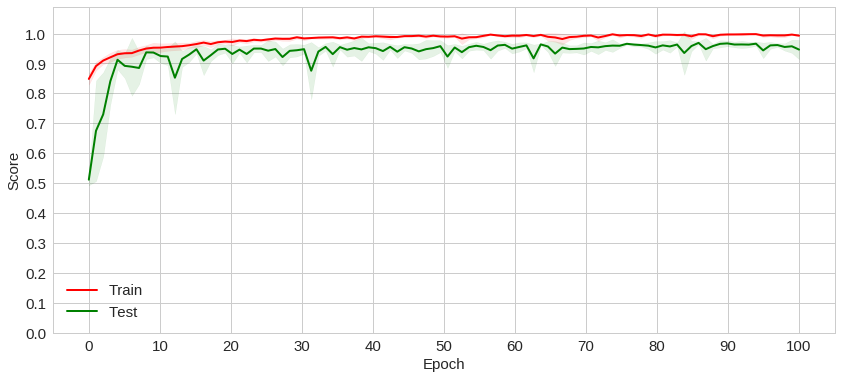

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

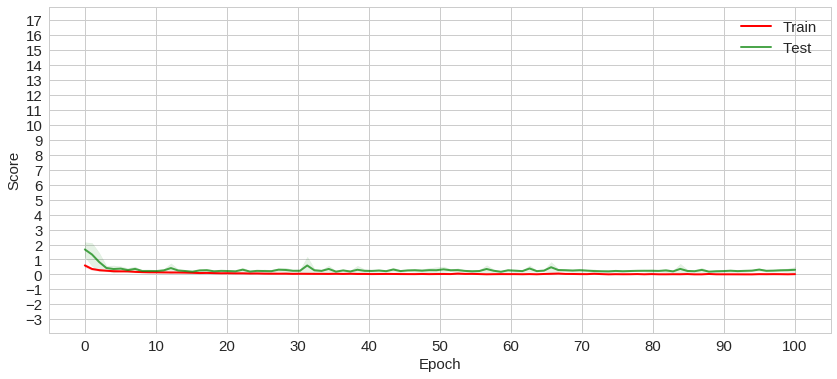

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

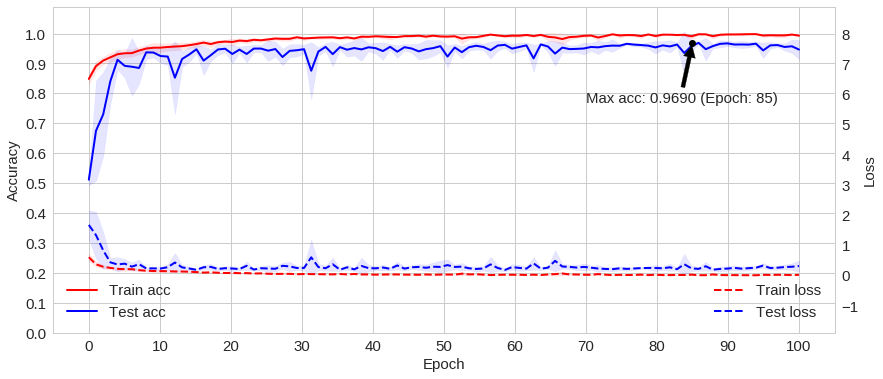

In [28]:
plot_mean(hist)